In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc

from sklearn.metrics import accuracy_score

import os
from dotenv import load_dotenv
import boto3
import mlflow
from io import BytesIO

from tqdm import tqdm
tqdm.pandas()

In [2]:
import warnings  
warnings.filterwarnings('ignore') 

### Доступы

In [3]:
# Загружаем переменные из .env файла
load_dotenv('/home/mle-user/mle_final/mle_final/.env')  # укажите полный путь

# Теперь переменные доступны через os.getenv()
DB_SOURCE_HOST = os.getenv('DB_SOURCE_HOST')
DB_SOURCE_PORT = os.getenv('DB_SOURCE_PORT')
DB_SOURCE_NAME = os.getenv('DB_SOURCE_NAME')
DB_SOURCE_USER = os.getenv('DB_SOURCE_USER')
DB_SOURCE_PASSWORD = os.getenv('DB_SOURCE_PASSWORD')

DB_DESTINATION_HOST = os.getenv('DB_DESTINATION_HOST')
DB_DESTINATION_PORT = os.getenv('DB_DESTINATION_PORT')
DB_DESTINATION_USER = os.getenv('DB_DESTINATION_USER')
DB_DESTINATION_PASSWORD = os.getenv('DB_DESTINATION_PASSWORD')
DB_DESTINATION_NAME = os.getenv('DB_DESTINATION_NAME')

S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')


TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

### MLFlow

In [4]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

In [5]:
def save_file_s3(data_to_save, name):
    s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    endpoint_url='https://storage.yandexcloud.net',
    )
    data_to_save.to_parquet(f'{name}.parquet')
    s3.upload_file(f'{name}.parquet', S3_BUCKET_NAME, f'final_project/data/{name}.parquet')
    print(f"Файл загружен в Yandex S3")

In [6]:
def read_file_s3(file_name):
    s3 = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        endpoint_url='https://storage.yandexcloud.net',
    )
    parquet_buffer = BytesIO()

    s3.download_fileobj(S3_BUCKET_NAME, f'final_project/data/{file_name}.parquet', parquet_buffer)
    parquet_buffer.seek(0)

    # Читаем Parquet в DataFrame
    df_temp = pd.read_parquet(parquet_buffer, engine='pyarrow')
    
    return df_temp

### Данные

In [7]:
def down(df):
  for column, dtype in zip(df.columns, df.dtypes):
    dtype = str(dtype)
    # column_data = df[column]
    if any([_ in dtype for _ in ('int', 'float')]):
      column_min, column_max = df[column].min(), df[column].max()
      if 'int' in dtype:
        # if (column_min > np.iinfo(np.int8).min) and (column_max < np.iinfo(np.int8).max):
        #   df[column] = df[column].astype(np.int8)
        if (column_min > np.iinfo(np.int16).min) and (column_max < np.iinfo(np.int16).max):
          df[column] = df[column].astype(np.int16)
        elif (column_min > np.iinfo(np.int32).min) and (column_max < np.iinfo(np.int32).max):
          df[column] = df[column].astype(np.int32)
        else:
          df[column] = df[column].astype(np.int64)

      else:
        # if (column_min > np.finfo(np.float16).min) and (column_max < np.finfo(np.float16).max):
        #   df[column] = df[column].astype(np.float16)
        if (column_min > np.finfo(np.float32).min) and (column_max < np.finfo(np.float32).max):
          df[column] = df[column].astype(np.float32)
        else:
          df[column] = df[column].astype(np.float64)

    # elif dtype == 'object':
    #   df[column] = df[column].astype('category')

  return df

In [8]:
def correct_df(df):
    df['age'] = df['age'].apply(lambda x: x.strip() if isinstance(x, str) else x)
    df['age'] = df['age'].replace('NA', np.nan)
    df['age'] = df['age'].astype(float)

    df['fecha_alta'] = pd.to_datetime(df['fecha_alta'])


    df['antiguedad'] = df['antiguedad'].apply(lambda x: x.strip() if isinstance(x, str) else x)
    df['antiguedad'] = df['antiguedad'].replace('NA', np.nan)
    df['antiguedad'] = df['antiguedad'].astype(float)
    df.loc[df['antiguedad']==-999999, 'antiguedad'] = np.nan

    df['indrel_1mes'] = df['indrel_1mes'].replace('P', 99)
    df['indrel_1mes'] = df['indrel_1mes'].astype('float')

    df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])
    df['ult_fec_cli_1t'] = pd.to_datetime(df['ult_fec_cli_1t'])

    # удалим признаки где более 99% заполнено одним значением
    cols_to_del = ['ind_empleado', 'pais_residencia', 'indrel_1mes', 'indresi', 'conyuemp', 'indfall', 'tipodom']
    df = df.drop(cols_to_del, axis=1)

    return df

In [9]:
try:
    df = read_file_s3('df_clean')
    print('Файл загружен из S3')
except:
    df = pd.read_csv('/home/mle-user/mle_final/mle_final/data/train_ver2.csv.zip')
    df = correct_df(df)
    df = down(df)
    save_file_s3(df, 'df_clean')

gc.collect()

Файл загружен из S3


2376

### Модель

#### Построение таргета, метрика

Для обучения в качестве таргета возьмем факт приобретения продукта.

Метрика - accuracy.

Тренировочные данные - предпоследний месяц.

Валидация - последний месяц.

In [10]:
# продукты
target_cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

In [11]:
cols = [i for i in df.columns if i not in target_cols]

#### Подготовка обучающего датасета

In [12]:
def target_generate(df):
    # таргет
    df_long = df.melt(
        id_vars=['ncodpers', 'fecha_dato'],
        value_vars=target_cols,
        var_name='product_name',
        value_name='is_connected'
    )

    # много данных, уберем непопулярные продукты
    temp = df_long[df_long['is_connected']==1]['product_name'].value_counts(normalize=True).reset_index()
    top_product = temp[temp['proportion']>0.01]['product_name'].to_list()

    df_long = df_long[df_long['product_name'].isin(top_product)]

    df_long = df_long[df_long['fecha_dato']>='2016-04-01']
    df = df[df['fecha_dato']>='2016-04-01']
    majority_class = df_long[df_long['is_connected'] == 0]
    minority_class = df_long[df_long['is_connected'] == 1]

    # Для каждого id оставляем только 30% записей с таргетом 0
    sampled_majority = majority_class.groupby(['ncodpers', 'fecha_dato'], group_keys=False).sample(
        frac=0.3, 
        random_state=42
    )

    df_long = pd.concat([sampled_majority, minority_class], ignore_index=True)
    df = df_long.merge(df[cols], how='left', on=['ncodpers', 'fecha_dato'])
    del df_long

    return df


In [13]:
try:
    df = read_file_s3('df_target')
    print('Файл загружен из S3')
except:
    df = target_generate(df)
    save_file_s3(df, 'df_target')

gc.collect()

Файл загружен из S3


2562

In [14]:
df.shape

(9278261, 19)

In [15]:
df['is_connected'].value_counts(normalize=True)

is_connected
0.0    0.74076
1.0    0.25924
Name: proportion, dtype: float64

#### Базовая модель

In [16]:
for i in ['fecha_dato', 'ncodpers', 'fecha_alta',
          'ult_fec_cli_1t']:
    cols.remove(i)

cols.append('product_name')

In [17]:
df.head()

,ncodpers,fecha_dato,product_name,is_connected,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,tiprel_1mes,indext,canal_entrada,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,15889,2016-04-28,ind_nom_pens_ult1,0.0,V,56.0,1995-01-16,0.0,254.0,1.0,None,A,N,KAT,28.0,MADRID,1.0,326124.90625,01 - TOP
1,15889,2016-04-28,ind_ctop_fin_ult1,0.0,V,56.0,1995-01-16,0.0,254.0,1.0,None,A,N,KAT,28.0,MADRID,1.0,326124.90625,01 - TOP
2,15889,2016-04-28,ind_reca_fin_ult1,0.0,V,56.0,1995-01-16,0.0,254.0,1.0,None,A,N,KAT,28.0,MADRID,1.0,326124.90625,01 - TOP
3,15889,2016-05-28,ind_cno_fin_ult1,0.0,V,56.0,1995-01-16,0.0,255.0,1.0,None,A,N,KAT,28.0,MADRID,1.0,326124.90625,01 - TOP
4,15889,2016-05-28,ind_ctop_fin_ult1,0.0,V,56.0,1995-01-16,0.0,255.0,1.0,None,A,N,KAT,28.0,MADRID,1.0,326124.90625,01 - TOP


In [19]:
mask = df['fecha_dato']=='2016-05-28'

x_train = df[~mask].drop(['is_connected'], axis=1)
y_train = df[~mask]['is_connected']

x_test = df[mask].drop(['is_connected'], axis=1)
y_test = df[mask]['is_connected']



In [20]:
gc.collect()

0

### Модель классификации

Возьмем логрег, катбуст долго обучается

In [25]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
cat_features = ['sexo',
 'ind_nuevo',
 'indrel',
 'tiprel_1mes',
 'indext',
 'canal_entrada',
 'cod_prov',
 'nomprov',
 'ind_actividad_cliente',
 'segmento',
 'product_name']

In [23]:
for col in cat_features:
    try:
        x_train[col] = x_train[col].fillna(-99)
        x_test[col] = x_test[col].fillna(-99)
        x_train[col] = x_train[col].astype('int')
        x_test[col] = x_test[col].astype('int')
    except:
        x_train[col] = x_train[col].fillna('non_type')
        x_test[col] = x_test[col].fillna('non_type')

        x_train[col] = x_train[col].astype('str')
        x_test[col] = x_test[col].astype('str')

In [24]:
from sklearn.preprocessing import TargetEncoder
# закодируем заранее, так быстрее
enc_auto = TargetEncoder(smooth="auto")
for col in tqdm(cat_features):
    x_train[col] = enc_auto.fit_transform(x_train[[col]], y_train)
    x_test[col] = enc_auto.transform(x_test[[col]])

100%|██████████| 11/11 [00:33<00:00,  3.09s/it]


In [ ]:
# model_cat = CatBoostClassifier(random_state=13, 
#                              depth=6,
#                              iterations=1500, 
#                              verbose=100, 
#                             #  cat_features=cat_features,
#                              early_stopping_rounds=100,)

# model_cat.fit(x_train[cols], y_train,
#               eval_set = (x_test[cols], y_test)
#               )
# probs = model_cat.predict_proba(x_test[cols])

In [33]:
# importances = model_cat.feature_importances_
# df_importances = pd.DataFrame(index=x_train[cols].columns, columns=['importance'], data=importances)

# df_importances.sort_values(by='importance',ascending=False).head(50)

In [ ]:
# res = x_test[['ncodpers']]
# res['target'] = y_test
# res['preds'] = probs[:,1]

In [14]:
gc.collect()

0

In [26]:
x_train[cols] = x_train[cols].fillna(0)
x_test[cols] = x_test[cols].fillna(0)

clf = LogisticRegression(random_state=0).fit(x_train[cols], y_train,)
probs = clf.predict_proba(x_test[cols])

In [27]:
res = x_test[['ncodpers']]
res['target'] = y_test
res['preds'] = probs[:,1]

In [42]:
accuracy_score(res['target'], res['preds']>0.5)

0.839405249090509

In [29]:
gc.collect()

28

#### Логирование

In [33]:
EXPERIMENT_NAME = 'mle_final_project'
RUN_NAME = 'model_1'
REGISTRY_MODEL_NAME = 'model_base'

In [ ]:
metrics = {}
metrics['accuracy_test'] = accuracy_score(res['target'], res['preds']>0.5)

In [37]:
try:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
except:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [ ]:
pip_requirements = os.path.abspath("/home/mle-user/mle_final/requirements.txt")
signature = mlflow.models.infer_signature(x_test[cols], probs[:,1])
input_example = x_test[cols][:10]

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_params(clf.get_params())
    # метрики
    mlflow.log_metrics(metrics)

    # ваш код здесь
    model_info = mlflow.sklearn.log_model( 
			sk_model=clf,
            artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature = signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Successfully registered model 'model_base'.
2025/10/13 20:42:20 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_base, version 1
Created version '1' of model 'model_base'.


## Генерация признаков

In [58]:
try:
    df = read_file_s3('df_clean')
    print('Файл загружен из S3')
except:
    df = pd.read_csv('/home/mle-user/mle_final/mle_final/data/train_ver2.csv.zip')
    df = correct_df(df)
    df = down(df)
    save_file_s3(df, 'df_clean')

gc.collect()

Файл загружен из S3


6610

In [ ]:
df_long = df.melt(
    id_vars=['ncodpers', 'fecha_dato'],
    value_vars=target_cols,
    var_name='product_name',
    value_name='is_connected'
)

df_long = df_long[df_long['fecha_dato']>='2015-05-28']
gc.collect()

In [25]:

df_long['cumsum_id_product'] = df_long.groupby(['ncodpers', 'product_name'])['is_connected'].cumsum()
df_long['cumsum_id_product'] = df_long.groupby(['ncodpers', 'product_name'])['cumsum_id_product'].shift()
df_long_cumsum = df_long[df_long['fecha_dato']>='2016-03-01']
del df_long
df_long_cumsum['cumsum_id_product'] = df_long_cumsum['cumsum_id_product'].fillna(0)
save_file_s3(df_long_cumsum[['ncodpers','fecha_dato','product_name', 'cumsum_id_product']], 'df_long_cumsum')

gc.collect()

Файл загружен в Yandex S3


5584

In [72]:
df['ult_fec_cli_1t'] = pd.to_datetime(df['ult_fec_cli_1t'])

In [ ]:

mask = ~df['ult_fec_cli_1t'].isna()
df.loc[mask, 'period_prem'] = (df.loc[mask, 'fecha_dato'] - df.loc[mask, 'ult_fec_cli_1t']).dt.days

df['period_prem'] = df['period_prem'].fillna(-1)
df.loc[df['period_prem']<0, 'period_prem'] = -1

df_period = df[df['fecha_dato']>='2016-01-01']

save_file_s3(df_period[['ncodpers', 'fecha_dato', 'period_prem']], 'df_period')

gc.collect()

Файл загружен в Yandex S3


3506

#### Модель 2

In [19]:
df = read_file_s3('df_target')

In [20]:
df_period = read_file_s3('df_period')

df = df.merge(df_period, how='left', on=['ncodpers', 'fecha_dato'])
cols.append('period_prem')

del df_period
gc.collect()

4064

In [21]:
df_long_cumsum = read_file_s3('df_long_cumsum')

df = df.merge(df_long_cumsum, how='left', on=['ncodpers','fecha_dato','product_name'])
cols.append('cumsum_id_product')

del df_long_cumsum
gc.collect()

5235

In [22]:
mask = df['fecha_dato']=='2016-05-28'

x_train = df[~mask].drop(['is_connected'], axis=1)
y_train = df[~mask]['is_connected']

x_test = df[mask].drop(['is_connected'], axis=1)
y_test = df[mask]['is_connected']

In [23]:
dict_encoders = {}
for col in cat_features:
    try:
        x_train[col] = x_train[col].fillna(-99)
        x_test[col] = x_test[col].fillna(-99)
        x_train[col] = x_train[col].astype('int')
        x_test[col] = x_test[col].astype('int')
    except:
        x_train[col] = x_train[col].fillna('non_type')
        x_test[col] = x_test[col].fillna('non_type')

        x_train[col] = x_train[col].astype('str')
        x_test[col] = x_test[col].astype('str')

from sklearn.preprocessing import TargetEncoder
# закодируем заранее, так быстрее
for col in tqdm(cat_features):
    enc_auto = TargetEncoder(smooth="auto")
    x_train[col] = enc_auto.fit_transform(x_train[[col]], y_train)
    x_test[col] = enc_auto.transform(x_test[[col]])

    dict_encoders[col] = enc_auto

100%|██████████| 11/11 [00:33<00:00,  3.04s/it]


In [34]:
# model_cat = CatBoostClassifier(random_state=13, 
#                              depth=6,
#                              iterations=1500, 
#                              verbose=100, 
#                             #  cat_features=cat_features,
#                              early_stopping_rounds=100,)
# model_cat.fit(x_train[cols], y_train,
#               eval_set = (x_test[cols], y_test)
#               )
# probs = model_cat.predict_proba(x_test[cols])

In [26]:
x_train[cols] = x_train[cols].fillna(0)
x_test[cols] = x_test[cols].fillna(0)

clf = LogisticRegression(random_state=0).fit(x_train[cols], y_train,)
probs = clf.predict_proba(x_test[cols])

In [27]:
res = x_test[['ncodpers']]
res['target'] = y_test
res['preds'] = probs[:,1]

In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(res['target'], res['preds']>0.5)

0.9792847524133866

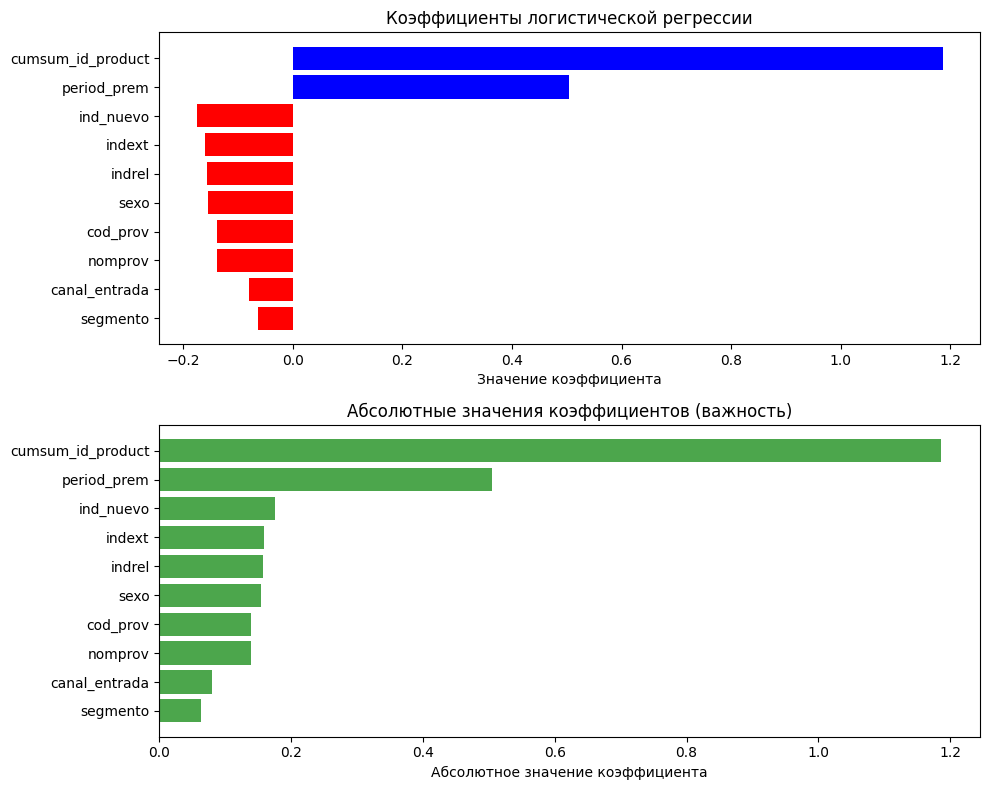

In [29]:
def plot_coefficient_importance(model, feature_names, top_n=10):
    """
    Визуализация важности признаков через коэффициенты модели
    """
    # Получаем коэффициенты
    coefficients = model.coef_[0]
    
    # Создаем DataFrame для удобства
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    })
    
    # Сортируем по абсолютному значению
    feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    
    # График коэффициентов
    plt.subplot(2, 1, 1)
    colors = ['red' if x < 0 else 'blue' for x in feature_importance['coefficient'].head(top_n)]
    plt.barh(range(top_n), feature_importance['coefficient'].head(top_n), color=colors)
    plt.yticks(range(top_n), feature_importance['feature'].head(top_n))
    plt.title('Коэффициенты логистической регрессии')
    plt.xlabel('Значение коэффициента')
    plt.gca().invert_yaxis()
    
    # График абсолютных значений
    plt.subplot(2, 1, 2)
    plt.barh(range(top_n), feature_importance['abs_coefficient'].head(top_n), color='green', alpha=0.7)
    plt.yticks(range(top_n), feature_importance['feature'].head(top_n))
    plt.title('Абсолютные значения коэффициентов (важность)')
    plt.xlabel('Абсолютное значение коэффициента')
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Использование
feature_importance_df = plot_coefficient_importance(clf, x_train[cols].columns.tolist())

In [ ]:
with open('/home/mle-user/mle_final/mle_final/models/logreg_model.pkl', 'wb') as f:  # 'wb' - write binary
    pickle.dump(clf, f)

#### Логирование

In [34]:
RUN_NAME = 'model_2'
REGISTRY_MODEL_NAME = 'model_new_features'

In [31]:
metrics = {}
metrics['accuracy_test'] = accuracy_score(res['target'], res['preds']>0.5)

In [35]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [36]:
pip_requirements = os.path.abspath("/home/mle-user/mle_final/requirements.txt")
signature = mlflow.models.infer_signature(x_test[cols], probs[:,1])
input_example = x_test[cols][:10]

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_params(clf.get_params())
    # метрики
    mlflow.log_metrics(metrics)

    # ваш код здесь
    model_info = mlflow.sklearn.log_model( 
			sk_model=clf,
            artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature = signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Successfully registered model 'model_new_features'.
2025/10/13 20:56:35 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_new_features, version 1
Created version '1' of model 'model_new_features'.
